# Support Vector Classification

Scikit-learn classification example involving the [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) class.

In [1]:
import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.svm import SVC, LinearSVC

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Dataset

We'll be using the same data generated from the [PyTorch neural networks example](../neural_networks/mlp_pytorch.ipynb).

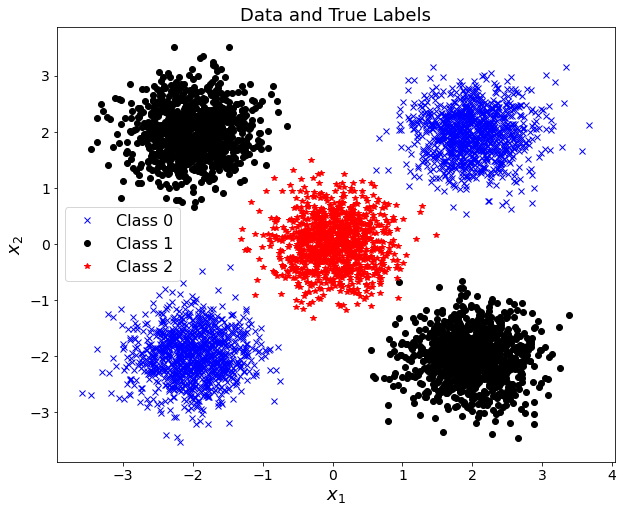

In [2]:
N = 1000

def create_data(N, noise=0.2):
    # Uses the same covariance matrix, scaled identity, for all Gaussians
    Sigma = noise * np.eye(2)
    # Five gaussian means specified to span a square and its centre
    Gs = [
        mvn(mean=[2, 2], cov=Sigma),
        mvn(mean=[-2, -2], cov=Sigma),
        mvn(mean=[2, -2], cov=Sigma),
        mvn(mean=[-2, 2], cov=Sigma),
        mvn(mean=[0, 0], cov=Sigma),
    ]
    # Draw random variable samples and assign labels, note class 3 has less samples altogether
    X = np.concatenate([G.rvs(size=N) for G in Gs])
    y = np.concatenate((np.zeros(N), np.zeros(N), np.ones(N), np.ones(N), 2 * np.ones(N)))
    
    # Will return an X and y of shapes (5*N, 2) and (5*N)
    # Representing our dataset of 2D samples
    return X, y


X, y = create_data(N)
C = len(np.unique(y))

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.legend()
plt.show()

## Support Vector Machines (SVMs) & Kernels

Here we make use of a few useful scikit-learn features, for both SVMs and general machine learning pipelines:
- [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html); a useful utility function for sequentially applying transforms to your data prior to feeding into an estimator, e.g. a Support Vector Classifier. Not really necessary in this dataset with Gaussian distributed samples, but a useful function to be aware of.
- [Kernels](https://scikit-learn.org/stable/modules/svm.html#kernel-functions), which are functions that perform pairwise similarity comparisons between input data examples, e.g. $\mathbf{x}^{(i)}$ and $\mathbf{x}^{(j)}$. The benefit of applying these functions, sometimes denoted as $K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$, is that we can enable the SVM to learn features over a very high $n$-dimensional space without ever needing to deal with the explicit representation of these features. This is known as the [Kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick).

Please refer to other additional resources on kernels, but for now we'll briefly walk through how to implement SVMs for classification using different kernel functions. First, we provide a contour plotting utility function for predictions made by some classifier on a grid of inputs:

In [3]:
def plot_classifier_predictions(classifier, n_samples=100):
    # Create coordinate matrices determined by the sample space
    xx, yy = np.meshgrid(np.linspace(-4, 4, n_samples), np.linspace(-4, 4, n_samples))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Matrix of predictions on a grid of samples
    y_pred = classifier.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, alpha=0.2)

### Linear Kernel

Linear kernels take on the form:
    
$$ K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \rangle = \sum_{k=1}^n x_k^{(i)}x_k^{(j)}, $$

where $\langle \mathbf{a}, \mathbf{b}\rangle$ is the same notation as the dot product between these two vectors $\mathbf{a}^\intercal \mathbf{b}$. Let's now look at an example of an SVM classifier with a linear kernel function:

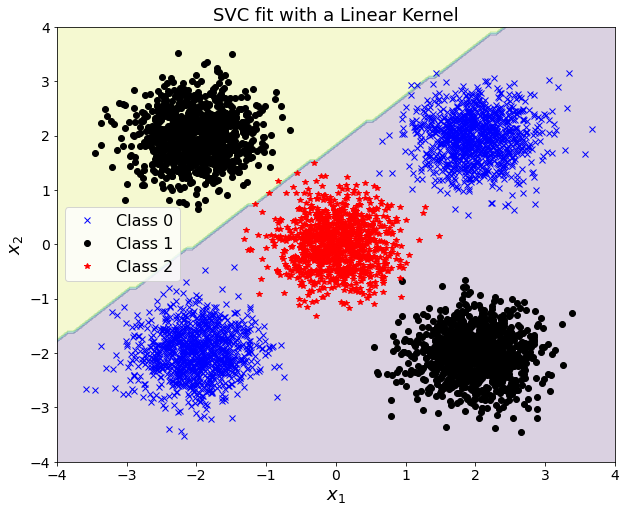

In [4]:
# SVC with a linear kernel
# Pipeline of sequentially applied transforms before producing the final estimation, e.g. Support Vector Classifier
linear_svc = make_pipeline(StandardScaler(), SVC(kernel='linear'))
# Can also use LinearSVC, which is a faster more versatile implementation than SVC with a "linear" kernel
# linear_svc = make_pipeline(StandardScaler(), LinearSVC())
# Fit SVM to data
linear_svc.fit(X, y)

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("SVC fit with a Linear Kernel")
plt.legend()
plot_classifier_predictions(linear_svc)
plt.show()

### Polynomial Kernel

Polynomial kernels take on the form:
    
$$ K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = (\langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \rangle + c)^d, $$

where $d$ is the degree of the polynomial and $c \geq 0$ is a parameter that controls the relative weighting of the higher-order and lower-order terms.

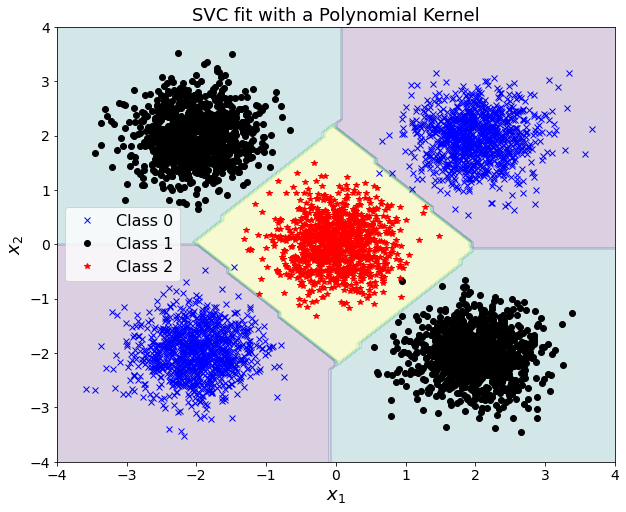

In [5]:
# SVC with a quadratic transformation of the input features
polynomial_svc = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=2))
polynomial_svc.fit(X, y)

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("SVC fit with a Polynomial Kernel")
plt.legend()
plot_classifier_predictions(polynomial_svc)
plt.show()

### Gaussian/Radial Basis Function (RBF) Kernel

Gaussian or RBF (or also squared exponential) kernels take on the form:
    
$$ K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \exp \left(-\frac{||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2}{2\sigma^2}\right), $$

where this measure is close to 1 when $\mathbf{x}^{(i)}$ and $\mathbf{x}^{(j)}$ are "similar", and 0 when they are far apart. The parameter $\sigma$ is the "bandwidth" of the kernel or the standard deviation of a Gaussian function.

If interested in reading about the hyperparameters selected below, check out [this doc](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py). In essence, the $C$ parameter is equivalent to $\lambda$ from the [other SVM notebook](svm.ipynb), which is a relevant regularization parameter for the above kernels as well. Whilst $\gamma = \frac{1}{2\sigma^2}$, such that large $\gamma$ means small variance or spread in the decision region, and vice versa for small $\gamma$, i.e. large variance (constrained model complexity).

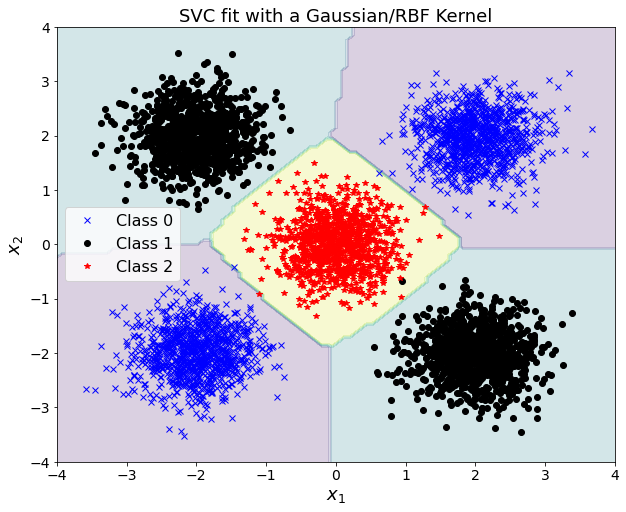

In [6]:
# SVC with Gaussian/RBF kernel
rbf_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=0.7, C=1.0))
rbf_svc.fit(X, y)

plt.figure(figsize=(10,8))
plt.plot(X[y==0, 0], X[y==0, 1], 'bx', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'ko', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'r*', label="Class 2");
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("SVC fit with a Gaussian/RBF Kernel")
plt.legend()
plot_classifier_predictions(rbf_svc)
plt.show()
plt.show()

### Which Kernel to Use?

The "kernel trick" is not limited to SVMs and can be applied to any linear models where dot products of the inputs are present, e.g. linear regression, SVMs, PCA, and so forth. Kernels are a generalization of the inner-product, or "similarity", between pairs of inputs. The "trick" is that they can map inputs $\mathbf{x}$ to features $\phi(\mathbf{x})$ in a high-dimensional space by computing a modified dot product between inputs in the original low-dimensional data space, without ever explicitly transforming the data using $\phi$.

But how do we choose a kernel function $K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$? As you might expect, selecting the right kernel for your dataset is a hyperparameter selection process. That being said, the <b>linear kernel</b> is fast, less prone to overfitting, and suitable for high-dimensional data assumed to be linearly separable, or close to it. This is because the data is not requiring any further transformation, given it is already in a higher $n$-space. If this kernel fails though and your data is not linearly separable, then the <b>RBF kernel</b> is the next most popular choice and a reliable bet. Though keep in mind that this significantly increases the training time, especially for large $N$ datasets. 

## References

Dataset adapted from example found in:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}